### Library 

In [409]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

path_main_folder = '/home/antorosi/Documents/AutoEncoder'
sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE
from conso.load_shape_data import *  
from conso.conso_helpers import plot_latent_space_projection

### Load and shape data 

In [410]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [411]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [412]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [413]:
# Change ganularity ?
name_granu = '15m'
data_conso_df = change_granularity(data_conso_df, granularity="15min")

In [414]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

### Build dataset 

In [415]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = x_conso.ds.max()
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [416]:
# Normalize x_conso
type_scaler = 'standard'
dict_xconso = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [417]:
name_type_cond = 'm-wd'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['month', 'weekday']

In [418]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

### Build model

In [419]:
path_out = os.path.join(path_main_folder, 'out')

In [420]:
name_model = 'cvae_conso_e48-24-12_d12-24-48_z2_gran-{}_x-{}_cond-{}'.format(name_granu, name_type_x, name_type_cond)

In [421]:
name_model

'cvae_conso_e48-24-12_d12-24-48_z2_gran-15m_x-c_cond-m-wd'

In [422]:
# Parameters
cond_dim = dataset['train']['x'][1].shape[1]
e_dims=[48,24,12]
d_dims=[12,24,48]
z_dim=2
beta = 0.2

In [423]:
model = CVAE(cond_dim=cond_dim, 
             e_dims=e_dims, 
             d_dims=d_dims, 
             z_dim=z_dim, 
             beta=beta,
             name=name_model, 
             output=path_out)

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6856        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]              

### Trainning model 



--- START TRAINING ---

Epoch 1/200
1830/1830 [==============================] - 1s 592us/step - loss: 57.4632 - kl_loss: 11.0320 - recon_loss: 55.2568
Epoch 2/200
1830/1830 [==============================] - 0s 77us/step - loss: 7.1005 - kl_loss: 8.1922 - recon_loss: 5.4621
Epoch 3/200
1830/1830 [==============================] - 0s 80us/step - loss: 4.3885 - kl_loss: 6.3675 - recon_loss: 3.1150
Epoch 4/200
1830/1830 [==============================] - 0s 84us/step - loss: 3.7434 - kl_loss: 5.8090 - recon_loss: 2.5816
Epoch 5/200
1830/1830 [==============================] - 0s 84us/step - loss: 3.3717 - kl_loss: 5.2662 - recon_loss: 2.3185
Epoch 6/200
1830/1830 [==============================] - 0s 83us/step - loss: 3.2460 - kl_loss: 5.0687 - recon_loss: 2.2323
Epoch 7/200
1830/1830 [==============================] - 0s 81us/step - loss: 3.0673 - kl_loss: 4.9512 - recon_loss: 2.0771
Epoch 8/200
1830/1830 [==============================] - 0s 83us/step - loss: 2.9563 - kl_loss: 4.8422

1830/1830 [==============================] - 0s 78us/step - loss: 1.6091 - kl_loss: 3.7606 - recon_loss: 0.8569
Epoch 67/200
1830/1830 [==============================] - 0s 79us/step - loss: 1.6040 - kl_loss: 3.7605 - recon_loss: 0.8520
Epoch 68/200
1830/1830 [==============================] - 0s 79us/step - loss: 1.5865 - kl_loss: 3.7412 - recon_loss: 0.8383
Epoch 69/200
1830/1830 [==============================] - 0s 77us/step - loss: 1.5954 - kl_loss: 3.7632 - recon_loss: 0.8428
Epoch 70/200
1830/1830 [==============================] - 0s 76us/step - loss: 1.6003 - kl_loss: 3.7536 - recon_loss: 0.8496
Epoch 71/200
1830/1830 [==============================] - 0s 77us/step - loss: 1.5788 - kl_loss: 3.7665 - recon_loss: 0.8255
Epoch 72/200
1830/1830 [==============================] - 0s 78us/step - loss: 1.5808 - kl_loss: 3.7466 - recon_loss: 0.8314
Epoch 73/200
1830/1830 [==============================] - 0s 78us/step - loss: 1.5727 - kl_loss: 3.7270 - recon_loss: 0.8273
Epoch 74/200


1830/1830 [==============================] - 0s 78us/step - loss: 1.4494 - kl_loss: 3.5846 - recon_loss: 0.7325
Epoch 132/200
1830/1830 [==============================] - 0s 81us/step - loss: 1.4345 - kl_loss: 3.5658 - recon_loss: 0.7213
Epoch 133/200
1830/1830 [==============================] - 0s 81us/step - loss: 1.4564 - kl_loss: 3.5861 - recon_loss: 0.7391
Epoch 134/200
1830/1830 [==============================] - 0s 82us/step - loss: 1.4333 - kl_loss: 3.5761 - recon_loss: 0.7181
Epoch 135/200
1830/1830 [==============================] - 0s 85us/step - loss: 1.4220 - kl_loss: 3.5291 - recon_loss: 0.7161
Epoch 136/200
1830/1830 [==============================] - 0s 80us/step - loss: 1.4291 - kl_loss: 3.5075 - recon_loss: 0.7276
Epoch 137/200
1830/1830 [==============================] - 0s 80us/step - loss: 1.4303 - kl_loss: 3.5210 - recon_loss: 0.7261
Epoch 138/200
1830/1830 [==============================] - 0s 76us/step - loss: 1.4313 - kl_loss: 3.4856 - recon_loss: 0.7342
Epoch 

1830/1830 [==============================] - 0s 78us/step - loss: 1.3753 - kl_loss: 3.3922 - recon_loss: 0.6968
Epoch 197/200
1830/1830 [==============================] - 0s 80us/step - loss: 1.3622 - kl_loss: 3.3533 - recon_loss: 0.6915
Epoch 198/200
1830/1830 [==============================] - 0s 86us/step - loss: 1.3794 - kl_loss: 3.4032 - recon_loss: 0.6988
Epoch 199/200
1830/1830 [==============================] - 0s 86us/step - loss: 1.3649 - kl_loss: 3.4195 - recon_loss: 0.6810
Epoch 200/200
1830/1830 [==============================] - 0s 83us/step - loss: 1.3646 - kl_loss: 3.3787 - recon_loss: 0.6889


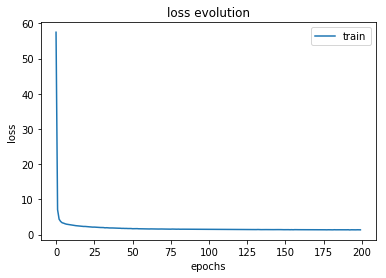

In [424]:
model.main_train(dataset, training_epochs=200, batch_size=20, verbose=True)

### Loading model 

In [425]:
#model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the results

In [426]:
name_set_plot = 'train'

In [427]:
x_encoded = model.encoder.predict(dataset[name_set_plot]['x'])[0]

In [428]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

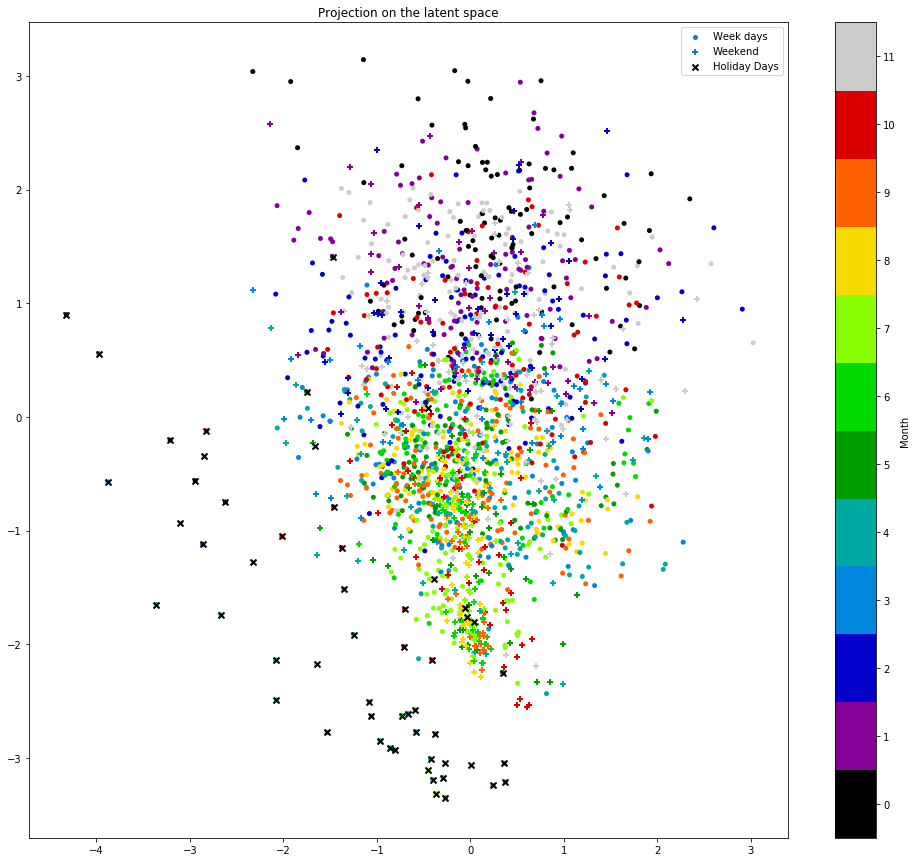

In [429]:
name_plot = 'z2_beta-{}_train-{}_set-{}_cond-{}_v2'.format(str(beta), name_train, name_set_plot,str(name_type_cond))
plot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=os.path.join(path_out,name_model,'results'), name=name_plot, 
                             pyplot=True, plotly = False)

In [47]:
x_encoded = model.encoder.predict([x, cond])

In [48]:
x_encoded[1]

array([[-5.9092875, -7.09972  ],
       [-5.8252373, -6.679961 ],
       [-6.2373667, -7.0688286],
       ...,
       [-4.4111757, -6.460076 ],
       [-5.246949 , -6.4631977],
       [-5.7494526, -6.565215 ]], dtype=float32)

In [37]:
x_encoded[0]

array([[ 0.50560117, -0.10510144],
       [ 0.04559893, -0.44405538],
       [-0.13649005, -0.7393909 ],
       ...,
       [ 2.0386896 , -0.8676998 ],
       [ 0.43687052, -1.3888265 ],
       [-0.04429651, -0.54366565]], dtype=float32)

In [33]:
np.exp(x_encoded[1])

array([0.06183312, 0.00093483], dtype=float32)

In [39]:
from matplotlib import pyplot as plt
plt.scatter(x_encoded[1])

TypeError: scatter() missing 1 required positional argument: 'y'

array([[-0.00059703, -0.00062802],
       [-0.00059703, -0.00062802],
       [-0.00059703, -0.00062802],
       ...,
       [-0.00059703, -0.00062802],
       [-0.00059703, -0.00062802],
       [-0.00059703, -0.00062802]], dtype=float32)

In [87]:
calendar_info

,ds,month,weekday,is_weekday,is_hd
0,2012-12-28,12,4,1,0.0
1,2012-12-29,12,5,0,0.0
2,2012-12-30,12,6,0,0.0
3,2012-12-31,12,0,1,0.0
4,2013-01-01,1,1,1,1.0
5,2013-01-02,1,2,1,0.0
6,2013-01-03,1,3,1,0.0
7,2013-01-04,1,4,1,0.0
8,2013-01-05,1,5,0,0.0
9,2013-01-06,1,6,0,0.0
